In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchsummary import summary
from einops import rearrange
import torch

In [27]:
# Transformations: Normalize and convert to tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# DataLoader
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [28]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.__setup_encoder()
        self.__setup_decoder()
    
    def __setup_encoder(self):
        self.enc_conv1 = nn.Conv2d(1, 512, kernel_size=3, stride=2, padding=1) # Output: 512 x 14 x 14
        self.enc_relu1 = nn.ReLU()
        self.enc_conv2 = nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1) # Output: 256 x 7 x 7
        self.enc_relu2 = nn.ReLU()
        self.enc_conv3 = nn.Conv2d(256, 128, kernel_size=7) # Output: 128 x 1 x 1
        self.enc_linear = nn.Linear(128, self.latent_dim) # Output: 1 x latent_dim

    def __setup_decoder(self):
        self.dec_linear = nn.Linear(self.latent_dim, 128) # Output: 1 x 128
        self.dec_conv1 = nn.ConvTranspose2d(128, 256, kernel_size=7) # Output: 512 x 7 x 7
        self.dec_relu1 = nn.ReLU()
        self.dec_conv2 = nn.ConvTranspose2d(256, 512, kernel_size=3, stride=2, padding=1, output_padding=1) # Output: 512 x 14 x 14
        self.dec_relu2 = nn.ReLU()
        self.dec_conv3 = nn.ConvTranspose2d(512, 1, kernel_size=3, stride=2, padding=1, output_padding=1) # Output: 1 x 28 x 28
        self.dec_tanh = nn.Tanh()
    
    def encode(self, x):
        assert x.shape[-3:] == (1, 28, 28)
        x = self.enc_conv1(x)
        x = self.enc_relu1(x)
        x = self.enc_conv2(x)
        x = self.enc_relu2(x)
        x = self.enc_conv3(x)
        x = rearrange(x, 'b c h w -> b (c h w)') # Remove h, w dimensions which are 1
        x = self.enc_linear(x)
        return x
    
    def decode(self, latent):
        assert latent.shape[-1] == self.latent_dim
        x = self.dec_linear(latent)
        x = rearrange(x, 'b c -> b c 1 1') # Add h, w dimensions which are 1, prepare to add spatial information
        x = self.dec_conv1(x)
        x = self.dec_relu1(x)
        x = self.dec_conv2(x)
        x = self.dec_relu2(x)
        x = self.dec_conv3(x)
        x = self.dec_tanh(x)
        return x

    def forward(self, x):
        latent = self.encode(x)
        x_reconstructed = self.decode(latent)
        return x_reconstructed

In [29]:
latent_dim = 128

In [30]:
model = Autoencoder(latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# test encoder, decoder
img = torch.rand(1, 1, 28, 28).to(device)

assert model.encode(img).shape == (1, latent_dim)
assert model.decode(model.encode(img)).shape == (1, 1, 28, 28)

In [31]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 14, 14]           5,120
              ReLU-2          [-1, 512, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]       1,179,904
              ReLU-4            [-1, 256, 7, 7]               0
            Conv2d-5            [-1, 128, 1, 1]       1,605,760
            Linear-6                  [-1, 128]          16,512
            Linear-7                  [-1, 128]          16,512
   ConvTranspose2d-8            [-1, 256, 7, 7]       1,605,888
              ReLU-9            [-1, 256, 7, 7]               0
  ConvTranspose2d-10          [-1, 512, 14, 14]       1,180,160
             ReLU-11          [-1, 512, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]           4,609
             Tanh-13            [-1, 1, 28, 28]               0
Total params: 5,614,465
Trainable param

# See what happens if we try to reconstruct the original image from the compressed image without training

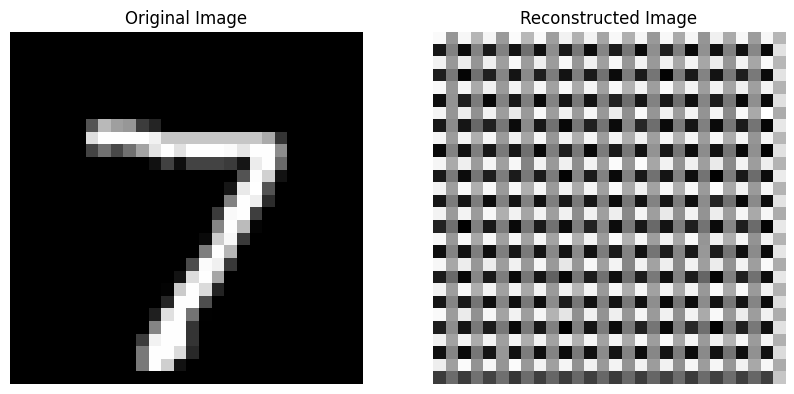

In [32]:
# Select a single image from the test dataset
single_image, _ = test_dataset[0]
single_image = single_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Pass the image through the encoder
with torch.no_grad():
    latent_vector = model.encode(single_image)
    reconstructed = model.decode(latent_vector)  # Pass the latent vector through the decoder
# Plot the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(single_image.cpu().view(28, 28), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed.cpu().view(28, 28), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()


Obviously without training we see artifacts.

# Train the model on MNIST dataset

In [33]:
# Training loop
num_epochs = 5
train_loss_history = []  # To store loss for plotting

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Update tqdm description with current loss
            t.set_postfix(loss=loss.item())

    # Average loss for the epoch
    avg_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5]: 100%|██████████| 469/469 [00:20<00:00, 23.39it/s, loss=0.0258]


Epoch [1/5], Loss: 0.1070


Epoch [2/5]: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s, loss=0.0175]


Epoch [2/5], Loss: 0.0205


Epoch [3/5]: 100%|██████████| 469/469 [00:19<00:00, 23.90it/s, loss=0.013] 


Epoch [3/5], Loss: 0.0147


Epoch [4/5]: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s, loss=0.0115] 


Epoch [4/5], Loss: 0.0121


Epoch [5/5]: 100%|██████████| 469/469 [00:17<00:00, 26.56it/s, loss=0.0109] 

Epoch [5/5], Loss: 0.0105


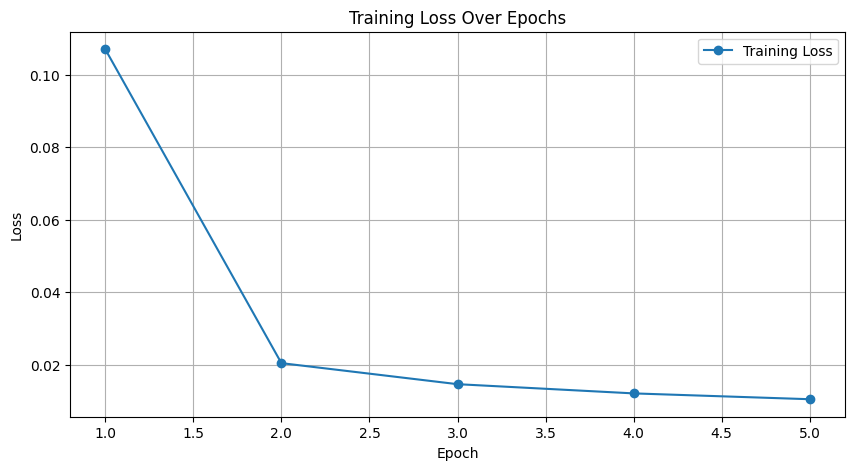

In [34]:
# Plot the loss history
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Visualize latent vector reconstruction

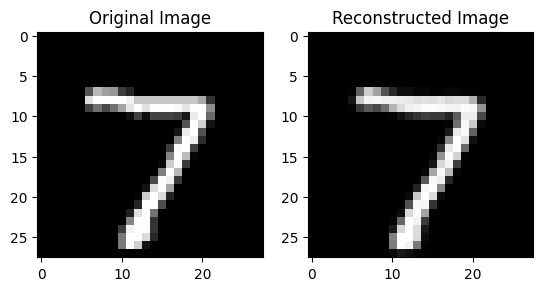

In [35]:
# Function to visualize results
def visualize_results(model, test_loader):
    model.eval()
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            reconstructed = model(images)
            break

    # Plot original and reconstructed images
    images = images.cpu()
    reconstructed = reconstructed.cpu()
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(images[0].squeeze(), cmap='gray')
    axes[0].set_title('Original Image')
    axes[1].imshow(reconstructed[0].squeeze(), cmap='gray')
    axes[1].set_title('Reconstructed Image')
    plt.show()

visualize_results(model, test_loader)


# Check if the model can denoise without explicitly training on noise data

In [36]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
    """
    Adds Gaussian noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    mean (float): Mean of the Gaussian noise.
    std (float): Standard deviation of the Gaussian noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clip(noisy_images, 0., 1.)
    return noisy_images

def add_salt_and_pepper_noise(images, salt_prob=0.1, pepper_prob=0.1):
    """
    Adds salt and pepper noise to a batch of images.
    
    Parameters:
    images (torch.Tensor): Batch of images.
    salt_prob (float): Probability of adding salt noise.
    pepper_prob (float): Probability of adding pepper noise.
    
    Returns:
    torch.Tensor: Noisy images.
    """
    noisy_images = images.clone()
    salt_mask = torch.rand_like(images) < salt_prob
    pepper_mask = torch.rand_like(images) < pepper_prob
    noisy_images[salt_mask] = 1.0
    noisy_images[pepper_mask] = 0.0
    return noisy_images

def sample_value(mean, std):
    value = torch.randn(1) * std + mean
    return value.clamp(0, 1).item()

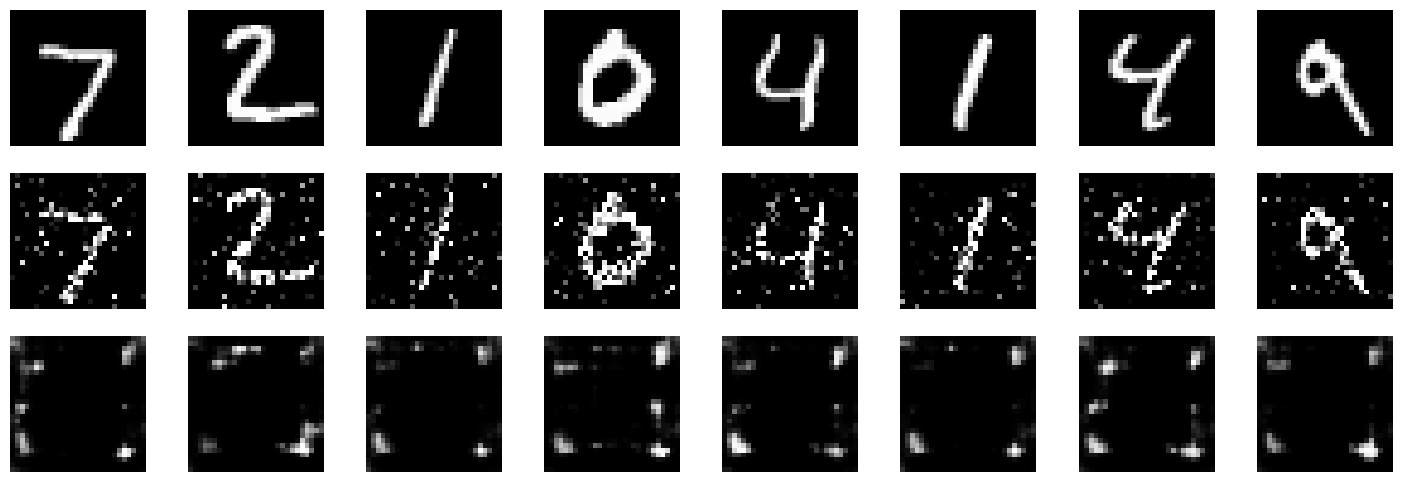

In [37]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add Gaussian noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.6, 0.2))

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed = model(noisy_images.to(device)).cpu()
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

The model can't denoise. We get bad outputs.

# Train the model to denoise

In [38]:
# Training loop
num_epochs = 5
train_loss_history = []  # To store loss for plotting

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    # Use tqdm for progress tracking
    with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]") as t:
        for images, _ in t:
            images = images.to(device)

            # Add noise to the images
            images = add_gaussian_noise(images, std=sample_value(0.8, 0.2))

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, images)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Update tqdm description with current loss
            t.set_postfix(loss=loss.item())

    # Average loss for the epoch
    avg_loss = train_loss / len(train_loader)
    train_loss_history.append(avg_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/5]: 100%|██████████| 469/469 [00:18<00:00, 25.47it/s, loss=0.0524]


Epoch [1/5], Loss: 0.0706


Epoch [2/5]: 100%|██████████| 469/469 [00:19<00:00, 24.39it/s, loss=0.0389]


Epoch [2/5], Loss: 0.0415


Epoch [3/5]: 100%|██████████| 469/469 [00:19<00:00, 24.63it/s, loss=0.05]  


Epoch [3/5], Loss: 0.0406


Epoch [4/5]: 100%|██████████| 469/469 [00:18<00:00, 24.78it/s, loss=0.062] 


Epoch [4/5], Loss: 0.0407


Epoch [5/5]: 100%|██████████| 469/469 [00:20<00:00, 23.36it/s, loss=0.0263]

Epoch [5/5], Loss: 0.0401


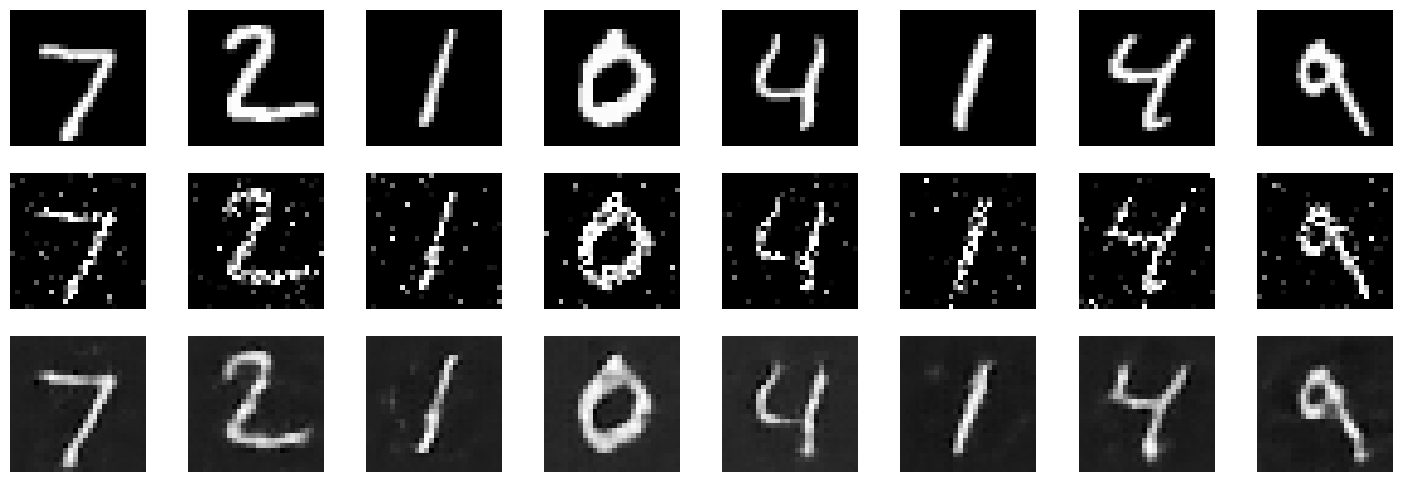

In [39]:
# Take 8 images from the test set, add noise and reconstruct
images, _ = next(iter(test_loader))
images = images[:8]

# Add noise
noisy_images = add_gaussian_noise(images, std=sample_value(0.7, 0.1))

# Reconstruct the images
model.eval()
with torch.no_grad():
    reconstructed = model(noisy_images.to(device)).cpu()
    # Plot original, noisy and reconstructed images
    fig, axes = plt.subplots(3, 8, figsize=(18, 6))
    for images, row in zip([images, noisy_images, reconstructed], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()

    

The model successfully denoises the data.

In [54]:
# Save the model
torch.save(model.state_dict(), 'autoencoder_after_noise_training.pth')

# Create interactive latent vector representation viewer

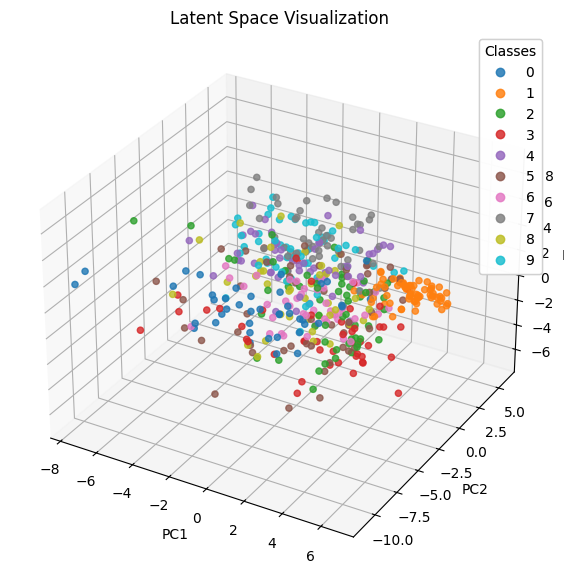

In [50]:
# Extract latent vectors from a subset of the test set
def extract_latent_vectors(loader, num_samples=500):
    model.eval()
    latent_vectors = []
    labels = []
    count = 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            latent = model.encode(images).view(images.size(0), -1)  # Flatten latent space

            latent_vectors.append(latent.cpu())
            labels.append(targets)
            count += images.size(0)

            if count >= num_samples:  # Stop after collecting enough samples
                break

    latent_vectors = torch.cat(latent_vectors, dim=0)[:num_samples]
    labels = torch.cat(labels, dim=0)[:num_samples]
    return latent_vectors.numpy(), labels.numpy()

latent_vectors, labels = extract_latent_vectors(test_loader)

# Step 3: Reduce dimensionality to 3D
pca = PCA(n_components=3)
latent_3d = pca.fit_transform(latent_vectors)

# Step 4: Visualize the latent vectors in 3D space
def plot_latent_space(latent_3d, labels):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2],
                         c=labels, cmap='tab10', alpha=0.8)
    ax.set_title('Latent Space Visualization')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Add legend
    legend = ax.legend(*scatter.legend_elements(), title="Classes", loc="upper right")
    ax.add_artist(legend)

    plt.show()

plot_latent_space(latent_3d, labels)

In [51]:
import plotly.graph_objects as go
import numpy as np
import base64
from PIL import Image
from io import BytesIO

# Function to decode latent vector and get the reconstructed image
def get_reconstructed_image(latent_vector, model):
    latent_vector = torch.tensor(latent_vector, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed = model.decoder_cnn(latent_vector)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        # Normalize to [0, 255] and convert to uint8 for display
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min()) * 255
        return Image.fromarray(reconstructed[0].astype(np.uint8))

# Function to encode an image as base64
def image_to_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

# Interactive 3D plot with hover interaction
def create_interactive_3d_plot_with_hover(latent_3d, labels, model):
    fig = go.Figure()

    # Placeholder image (transparent)
    placeholder_image = Image.new("RGBA", (28, 28), (255, 255, 255, 0))
    placeholder_base64 = image_to_base64(placeholder_image)

    # Precompute reconstructed images
    reconstructed_images = []
    for latent_vector in latent_3d:
        reconstructed_images.append(image_to_base64(get_reconstructed_image(latent_vector, model)))

    # Add points to the figure
    for label in set(labels):
        idx = labels == label
        fig.add_trace(go.Scatter3d(
            x=latent_3d[idx, 0],
            y=latent_3d[idx, 1],
            z=latent_3d[idx, 2],
            mode='markers',
            marker=dict(size=5, opacity=0.8),
            name=f"Class {label}",
            customdata=[reconstructed_images[i] for i in range(len(latent_3d)) if labels[i] == label],  # Attach images
            hovertemplate="<extra></extra>"  # Suppress default hover info
        ))

    # Add JavaScript for hover interaction
    fig.update_layout(
        title="Latent Space Visualization",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3",
        ),
        margin=dict(l=0, r=0, b=0, t=40),
        updatemenus=[
            {
                "buttons": [
                    {
                        "args": None,
                        "label": "Add Hover Interaction",
                        "method": "relayout",
                        "args2": {
                            "customdata": reconstructed_images,
                            "hovermode": "closest"
                        }
                    }
                ]
            }
        ]
    )

    fig.add_trace(go.Image())


In [52]:

# Step 1: Create an interactive 3D scatter plot with Plotly
def create_interactive_3d_plot(latent_3d, labels):
    fig = go.Figure()

    # Add points to the figure
    for label in set(labels):
        idx = labels == label
        fig.add_trace(go.Scatter3d(
            x=latent_3d[idx, 0],
            y=latent_3d[idx, 1],
            z=latent_3d[idx, 2],
            mode='markers',
            marker=dict(size=5, opacity=0.8),
            name=f"Class {label}"
        ))

    # Update layout for better interactivity
    fig.update_layout(
        title="Latent Space Visualization",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3",
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    return fig

# Step 2: Generate the plot
interactive_plot = create_interactive_3d_plot(latent_3d, labels)

# Step 3: Save the plot as an HTML file
interactive_plot.write_html("latent_space_visualization1.html")
print("Interactive plot saved as latent_space_visualization1.html")


Interactive plot saved as latent_space_visualization1.html


In [53]:


# Function to generate a reconstructed image from a latent vector using the model
def get_reconstructed_image(latent_vector, model):
    latent_vector = torch.tensor(latent_vector, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        reconstructed = model.decode(latent_vector)
        reconstructed = reconstructed.squeeze(0).cpu().numpy()
        # Normalize to [0, 255] and convert to uint8 for display
        reconstructed = (reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min()) * 255
        return Image.fromarray(reconstructed[0].astype(np.uint8))

# Function to convert a PIL image to a base64 string
def image_to_base64(image):
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")

# Interactive 3D plot with hover interaction
def create_interactive_3d_plot(latents_and_latents3d, labels, model):
    latent_vectors, latent_3d = latents_and_latents3d

    fig = go.Figure()

    # Placeholder transparent image
    placeholder_image = Image.new("L", (28, 28), color=255)  # Gray image as placeholder
    placeholder_base64 = image_to_base64(placeholder_image)

    # Precompute reconstructed images as base64 strings
    reconstructed_images = [image_to_base64(get_reconstructed_image(latent, model)) for latent in latent_vectors]

    # Add points to the figure
    for label in np.unique(labels):
        idx = labels == label
        fig.add_trace(go.Scatter3d(
            x=latent_3d[idx, 0],
            y=latent_3d[idx, 1],
            z=latent_3d[idx, 2],
            mode='markers',
            marker=dict(size=5, opacity=0.8),
            name=f"Class {label}",
            customdata=[reconstructed_images[i] for i in range(len(latent_3d)) if labels[i] == label],
            hoverinfo='skip'  # Suppress default hover info
        ))

    # Embed JavaScript for hover-based interactivity
    fig.update_layout(
        title="Latent Space Visualization",
        scene=dict(
            xaxis_title="PC1",
            yaxis_title="PC2",
            zaxis_title="PC3",
        ),
        margin=dict(l=0, r=0, b=0, t=40),
    )

    fig.write_html(
        "latent_space_visualization.html",
        full_html=True,
        include_plotlyjs="cdn",
        post_script=f"""
        <script>
        document.querySelectorAll('.scatter3d').forEach(trace => {{
            trace.on('plotly_hover', function(data) {{
                const imgSrc = data.points[0].data.customdata[data.points[0].pointIndex];
                document.getElementById("reconstructed-image").src = "data:image/png;base64," + imgSrc;
            }});
            trace.on('plotly_unhover', function() {{
                document.getElementById("reconstructed-image").src = "data:image/png;base64,{placeholder_base64}";
            }});
        }});
        </script>
        <div style="position: absolute; right: 20px; top: 20px;">
            <img id="reconstructed-image" src="data:image/png;base64,{placeholder_base64}" 
                 style="border: 1px solid black; width: 200px; height: 200px;" />
        </div>
        """
    )
    print("Interactive plot saved as latent_space_visualization2.html")

# Example usage:
# Assuming `latent_3d` is a NumPy array of shape (n_samples, 3), `labels` is a 1D array of class labels,
# and `model` is your trained autoencoder:
latents_and_latents3d = (latent_vectors, latent_3d)
create_interactive_3d_plot(latents_and_latents3d, labels, model)


Interactive plot saved as latent_space_visualization2.html
